# Identify problems and solutions in scientific text.

## The problem

I work in a fast-moving field where a large number of scientific papers are published every week. I don't have the time to read every paper that's published in my field - so how do I choose which ones to focus on? Right now, I skim their abstracts and decide which look interesting - but this takes a long time, and sometimes the abstract doesn't describe a paper well. Instead, there are two things I really want to know when deciding whether to read a paper:

1) What are the **problems** this paper is trying to address?
2) What are the **solutions** the authors propose?

## The solution

I want to train models that can pick out just those sentences in the text of a scientific paper that describe problems and proposed/identified solutions. That way, I can screen just these sentences, and decide whether these are problems/solutions that interest me.

## The approach

#### General approach
I will make use of a dataset published in [1] and available at [2] (see References at end of notebook). This dataset contains sentences extracted from scientific articles, and hand-annotated with the presence and location of problem and solution phrases within the sentence. I will use this dataset to train two classes of models:
1) **Problem sentence identifier** - that will identify sentences that contain a problem phrase
2) **Solution sentence identifier** - that will identify sentences that contain a solution phrase

#### Previous work
This original paper for this dataset [1] describes an approach to train a number of different machine learning classification models to predict whether a sentence contains a problem and/or a solution. These include logistic regression, Naive Bayes, and Support Vector Machine models. The authors achieve reasonable performance, namely 82.3% and 79.7% accuracy using their best-performing models to identify problems and solutions, respectively (SVMs using both bag-of-words and a number of syntactic features as predictors). A more recent paper [3] extended these results to implement deep neural network models to perform the same classification task. The best-performing classifiers were convolutional neural networks, which achieved 90% and 86% accuracy for problems and solutions, respectively.

#### My approach
I will first train a "traditional" ML model to perform the problem/non-problem and solution/non-solution classification tasks. Specifically, I will use a **Naive Bayes** model, because such models generally perform well on text data, and are easy to train.

Then, I will try a different approach using more recent advances in neural network architectures. I will take advantage of Google's open source **BERT** model, which is pre-trained on English natural texts. I will fine-tune this model (add a single-unit classification layer and run several training runs) to create a **Transformer**-based classifier that can identify problem sentences, and similary for solutions.

## Making the model usable

To demonstrate the utility of this model, I will feed it with a scientific paper, and ask it to identify the problems that the paper is trying to address, and the solutions that the authors propose.

## Conclusions

A simple Naive Bayes classifier did an OK job of classifying sentences as containing problems or solutions. However, fine-tuning a BERT model resulted in a much higher performance on test data. In fact, the performance of both the problem and solution BERT classifiers **exceeded the best published performance results** on this dataset.

##### Therefore, I have a developed a model that can very accuractely pick out problems and solutions from a scientific text, which will help me to parse the scientific literature much more efficiently!

In the future, I'd love to ftrain a Mamba model to perform this task, to see whether it can outperform my BERT models.

## Structure of this notebook
1. **Setup**
    - package imports
2. **Data import**
    - import the training and test datasets
3. **Naive Bayes classifiers**
    - Sentence preprocessing
    - Sentence embedding and padding
    - Model training and validation
    - Adding parameters
4. **BERT classifiers**
    - Sentence preprocessing
    - Model initialization
    - Training and validation
5. **Model comparison**
    - Testing both models on a held-out test dataset
6. **Model usage on full article**

## References
[1] - Heffernan, Kevin, and Simone Teufel. "Identifying problems and solutions in scientific text." Scientometrics 116 (2018): 1367-1382.

[2] - https://github.com/kevinheffernan/problem-solving-in-scientific-text/blob/main/dataset.tar.gz

[3] - Mishra, Rohit Bhuvaneshwar, and Hongbing Jiang. "Classification of Problem and Solution Strings in Scientific Texts: Evaluation of the Effectiveness of Machine Learning Classifiers and Deep Neural Networks." Applied Sciences 11.21 (2021): 9997.

## 1. Setup

In [1]:
# Import necessary packages

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokens import Doc
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from textblob import TextBlob
import re
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import time
from datetime import datetime
from datetime import timedelta
import random
import pickle
import urllib.request
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sjwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\sjwal\dw-task\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data import

In [2]:
# Import the training and test datasets
# (The test dataset will only be used at the end for comparing models)

training_file = 'training_docs_joint.jsonlines'
test_file = 'test_docs_joint.jsonlines'

def load_data_file(dataset_file):
    """Load a jsonl file and put in dataframe
    Args: dataset_file (str)
    Outputs: dataset (dataframe)
    """
    # Load each line
    data = []
    with open(dataset_file) as f:
        for line in f:
            data.append(json.loads(line))

    # Put in dataframe
    dataset = pd.DataFrame(data[0])
    for doc in data[1:]:
        dataset = pd.concat([dataset, pd.DataFrame(doc)])
    dataset.index = range(len(dataset))

    return dataset

dataset = load_data_file(training_file)
test_dataset = load_data_file(test_file)

#### Description of this dataset:

There are 4800 sentences in this dataset. For each piece of text, there are 5 sentences.

Each sentence is tokenized in `sentences`.

For each sentence, `ners` defines problem and solution statements (phrases within a sentence that describe problems or solutions). Specifically, it contains the indices of tokens defining several aspects of a problem statement:
- `Signal` - a word or short series of words indicating a problem
- `Root` - the cause or source of the problem (and whether this comes before (RIGHT) or after (LEFT) the signal)
- `Condition` - conditional or restrictive comments for the problem statement (and whether this comes before (RIGHT) or after (LEFT) the signal)
- `Complement` - more information about the problem, or an object pointed to by the problem statement  (and whether this comes before (RIGHT) or after (LEFT) the signal)

For solutions, only the start and end indices of the solution statement are given.

I want to train a model to predict whether a sentence contains a problem and/or a solution. So, let's count up the number of problems/solutions in each sentence in the dataset.

In [3]:
dataset['problem'] = 0
dataset['problem'] = dataset['ners'].apply(lambda x: sum([y.count('SIGNAL') for y in x]))
dataset['solution'] = 0
dataset['solution'] = dataset['ners'].apply(lambda x: sum([y.count('SOLUTION') for y in x]))

Are there any sentences that contain both a problem and a solution?

In [4]:
dataset[(dataset['problem'] > 0) & (dataset['solution'] > 0)]

,doc_key,ners,sentences,problem,solution
119,train_extract_20,"[[2, 2, ROOT-RIGHT], [3, 3, SIGNAL], [7, 18, S...","[To, solve, this, problem, ,, we, propose, a, ...",1,1
269,train_extract_45,"[[6, 6, ROOT-RIGHT], [7, 7, SIGNAL], [9, 34, S...","[In, this, paper, ,, we, handle, this, problem...",1,1
365,train_extract_61,"[[3, 5, ROOT-RIGHT], [6, 6, SIGNAL], [10, 21, ...","[To, address, the, above, -, mentioned, issues...",1,1
371,train_extract_62,"[[3, 10, SOLUTION], [13, 13, ROOT-RIGHT], [14,...","[This, paper, develops, a, general, framework,...",1,1
461,train_extract_77,"[[15, 22, SOLUTION], [25, 25, ROOT-RIGHT], [26...","[In, a, recent, paper, (, Erk, and, Padó, ,, 2...",1,1
...,...,...,...,...,...
4637,train_extract_773,"[[6, 23, SOLUTION], [27, 27, SIGNAL], [29, 34,...","[In, this, paper, ,, we, discuss, a, new, auto...",1,1
4643,train_extract_774,"[[8, 26, SOLUTION], [30, 32, ROOT-RIGHT], [33,...","[Our, goal, in, this, work, was, to, create, a...",1,1
4655,train_extract_776,"[[2, 8, SOLUTION], [11, 11, ROOT-RIGHT], [12, ...","[We, propose, a, new, unsupervised, model, for...",1,1
4733,train_extract_789,"[[6, 6, SIGNAL], [8, 11, ROOT-LEFT], [14, 22, ...","[Our, goal, is, to, address, the, weaknesses, ...",1,1


Yes - in fact, 86 of them. It probably makes most sense two train two models: one to identify whether a sentence contains a ***problem*** statement, and a second to identify whether a sentence contains a ***solution*** statement.

Finally, I will reduce the problem/solution labels to 1/0 (contains a problem/solution or not).

In [5]:
dataset['problem'].clip(upper=1, inplace=True)
dataset['solution'].clip(upper=1, inplace=True)


As input, I will start with just an embedding of the sentence. In improving the model, I could then try adding other features (e.g. polarity, syntax, POS).

What type of model could I use to predict sentences containing problems and solutions?
- Traditional ML classification models
    - Logistic regression
    - Naive Bayes
    - SVM
    - Random Forest
    - XGBoost
- Neural networks
    - Recurrent NN (e.g. LSTM)
    - Convolutional NN
    - Transformer - could fine-tune a pre-trained transformer (e.g. BERT, SBERT)

As a first pass, I will implement a **Naive Bayes** classifier, since it tends to perform well for classification of text data. I will first prepare the text data for training.

## 3. Naive Bayes classifiers

#### 3.1 Sentence preprocessing

I will apply a number of preprocessing steps to the text before embedding. Note that the sentences are already tokenized.
1. Lowercase
2. Change "'t" to "not" (it's important to include "not", because this can change a problem to non-problem or vice versa)
3. Lemmatize
4. Remove all punctuation (currently remove "?" but may want to keep this)
5. Remove stopwords except "not", "can".

First, check whether any of the sentences in the dataset have "n't" in them.

In [6]:
nots = dataset['sentences'].apply(lambda y: [x for x in y if "n\'t" in x])
nots[nots.str.len() > 0]

126     [n't]
130     [n't]
506     [n't]
1077    [n't]
1701    [n't]
2072    [n't]
3088    [n't]
3430    [n't]
3880    [n't]
4531    [n't]
4750    [n't]
Name: sentences, dtype: object

The tokenizer that was applied to this dataset separates "n't" as a separate token. So we can just replace this with "not".

In [7]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def preprocess_text(sentence):
    # Convert to lowercase
    sentence = [x.lower() for x in sentence]
    # Replace "n't" with "not"
    sentence = [re.sub(r"n\'t", "not", x) for x in sentence]
    # Lemmatization
    doc = Doc(nlp.vocab, sentence)
    sentence = [token.lemma_ for token in nlp(doc)]
    # Remove punctuation and stopwords
    punc = string.punctuation
    stop_words = set(stopwords.words('english'))
    sentence = [word for word in sentence if
                word not in stop_words and
                word not in punc or
                word in ['not', 'can']]
    sentence = [re.sub('\.', '', word) for word in sentence]
    return sentence

dataset['processed_sentence'] = dataset['sentences'].apply(preprocess_text)
dataset['processed_sentence']

0       [support, rule, extraction, sensitive, input, ...
1       [demand, extraction, can, slow, phrase, base, ...
2       [et, al, 2013, demonstrate, order, magnitude, ...
3       [however, popular, translation, model, use, ``...
4       [instead, need, pattern, match, phrase, extrac...
                              ...                        
4795    [also, use, datum, diacritic, show, improvemen...
4796    [currently, text, tospeech, speech, text, appl...
4797    [diacritization, system, restore, diacritic, s...
4798    [also, would, greatly, benefit, nonnative, spe...
4799    [propose, paper, statistical, approach, restor...
Name: processed_sentence, Length: 4800, dtype: object

#### 3.2 Sentence embedding

Next, I will embed the sentences so they can be used as input to the Naive Bayes model.

I will use test the performance of the model using two different approaches:
1. Vectorization using `TF-IDF`
2. Embedding using `Word2Vec`

I will implement Word2Vec using the `gensim` package. I could train a new embedding model based on the words in this corpus. However, I want the model to be able to generalize well to other datasets which might have different vocabularies. I will therefore use a pre-trained model (`google-news-300`, which has around 100 billion words).

Word2Vec has the advantage of taking a word's context into account, whereas TF-IDF does not. However, the Naive Bayes model (sklearn.model.fit()) takes a 2d array as input (vectors x sentences), so it can't handle a vector for every word (vectors x words x sentences). To get around this, I will try two different approaches to making the word embeddings into a 1d array for each sentence:
1. Take the **mean** embedding for each sentence
2. **Flatten** (or concatenate) the embeddings of each word (so an array with dims (50,300) becomes an array with dims (,15000)).

One possible extension of TF-IDF could be to include not just individual words, but also **ngrams** (e.g. bigrams, trigrams) as predictive features, since this may help to capture short phrases that indicate problems/solutions.

In [8]:
# TF-IDF vectorization

tfidf_vect = TfidfVectorizer()
dataset['tfidf_text'] = dataset['processed_sentence'].apply(lambda text: " ".join(set(text)))
X_tfidf = tfidf_vect.fit_transform(dataset['tfidf_text'])
X_tfidf = X_tfidf.toarray()

In [9]:
# Word2Vec embedding using google-news-300 model

w2v = api.load('word2vec-google-news-300')
def embed_words(sentence):
    sentence = np.stack([w2v[word] if word in w2v else w2v['unk'] for word in sentence])
    return sentence
dataset['embedded_sentence'] = dataset['processed_sentence'].apply(embed_words)

Before flattening the Word2Vec embeddings, I will pad the sentences so they all have the same length.

What is the distribution of sentence lengths in this dataset?

Maximum sentence length = 98


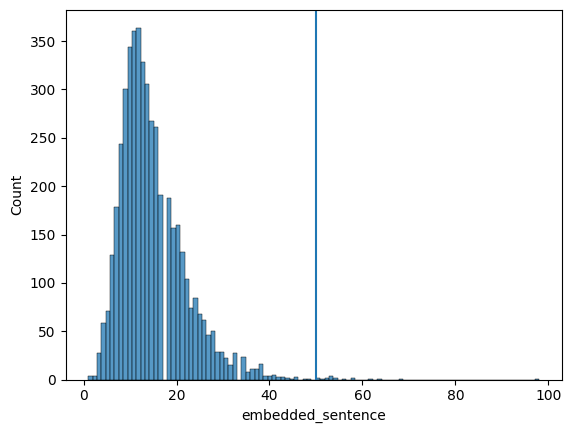

In [10]:
print(f"Maximum sentence length = {max(dataset['embedded_sentence'].str.len())}")
ax = sns.histplot(dataset['embedded_sentence'].str.len())
_ = ax.axvline(50)

To capture all sentences in the dataset, I will employ a length of 50 tokens. If the padding is too long (e.g. 100 tokens), it will negatively impact accuracy when flattening the embeddings.

I will try padding with embeddings = `w2v['unk']`. Alternatively, I could pad with zeros, or the mean of the embeddings of the tokens in the corpus - although because I'm not sure how representative the words in this corpus are of words in the inference corpus, the latter might not be a good approach.

In [11]:
# Pad with unk

def pad_sentences(sentence, max_len=50):
    sentence = np.vstack([sentence, np.tile(w2v['unk'],
                                            (max_len - len(sentence), 1))]) if len(sentence) <= max_len else sentence[:max_len]
    return sentence
dataset['padded_sentence'] = dataset['embedded_sentence'].apply(pad_sentences)

Finally, I will turn the word embeddings into 1d arrays by taking the mean or flattening the embeddings. For the mean, I will not include the padding so that the word are not drowned out by padding.

In [12]:
dataset['sentence_mean_emb'] = dataset['embedded_sentence'].apply(lambda x: x.mean(axis=0))
dataset['flat_sentence'] = dataset['padded_sentence'].apply(lambda x: x.flatten())

#### 3.3 Model training and validation

As a first approach, the only feature I will give to the model is the embeddings of words in the sentence. Later, I can try adding more features.

How many problem and solution sentences do we have in the training dataset?

In [13]:
print(f"Total number of sentences = {len(dataset)}")
print(f"Number of problem sentences = {sum(dataset['problem'] == 1)}")
print(f"Number of non-problem sentences = {sum(dataset['problem'] == 0)}")
print(f"Number of solution sentences = {sum(dataset['solution'] == 1)}")
print(f"Number of non-solution sentences = {sum(dataset['solution'] == 0)}")

Total number of sentences = 4800
Number of problem sentences = 1874
Number of non-problem sentences = 2926
Number of solution sentences = 800
Number of non-solution sentences = 4000


There is a class imbalance, with almost twice as many non-problem compared to problem sentences, and five times as many non-solution compared to solution sentences. Because of this, I will use a ***Complement Naive Bayes*** model, which can handle class imbalances well, and generally works well with text data.

In [14]:
# Define a function to train and evaluate the Naive Bayes model

def test_nb_model(X, Y, embedding=''):
    if type(dataset['sentence_mean_emb']) == pd.Series:
        X = np.array(list(X))
    Y = Y.values
    # Split train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=5)
    # MinMax scaling for Word2Vec because some values of embeddings are <0
    if embedding != 'tf-idf':
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    else:
        scaler = ''
    # Train Naive Bayes model
    model = ComplementNB()
    model.fit(X_train, Y_train) # Fit on training data
    predicted = model.predict(X_test) # Predict on test data
    # Calculate metrics - accuracy, precision, recall, and F1
    accuracy = metrics.accuracy_score(predicted, Y_test)
    print("Accuracy Score: ", accuracy)
    precision = metrics.precision_score(predicted, Y_test)
    print(f"Precision: {precision}")
    recall = metrics.recall_score(predicted, Y_test)
    print(f"Recall: {recall}")
    f1 = metrics.f1_score(predicted, Y_test)
    print(f"F1-score: {f1}")

    # Could use below to plot ROC curve and determine best decision threshold
    #predicted_prob = model.predict_proba(X_test)
    #metrics.RocCurveDisplay.from_predictions(Y_test, predicted_prob[:,1])
    return scaler, model

Train **problem** prediction models, and measure performance on validation data.

In [15]:
# Train & test using TF-IDF vectors.
print('Using TF-IDF: ')
pti_scaler, problem_tf_idf_model = test_nb_model(X_tfidf,
                                                 dataset['problem'],
                                                 embedding='tf-idf')

# Train & test using mean over word embeddings for each sentence.
print('\nUsing mean embedding: ')
pme_scaler, problem_mean_emb_model = test_nb_model(dataset['sentence_mean_emb'],
                                                   dataset['problem'])

# Train & test using flattened word embeddings for each sentence.
print('\nUsing flattened embedding: ')
pfe_scaler, problem_flat_emb_model = test_nb_model(dataset['flat_sentence'],
                                                   dataset['problem'])

Using TF-IDF: 


Accuracy Score:  0.7991666666666667
Precision: 0.6851441241685144
Recall: 0.7573529411764706
F1-score: 0.7194412107101281

Using mean embedding: 
Accuracy Score:  0.6991666666666667
Precision: 0.7006651884700665
Recall: 0.5830258302583026
F1-score: 0.6364551863041288

Using flattened embedding: 
Accuracy Score:  0.6675
Precision: 0.7361419068736141
Recall: 0.5424836601307189
F1-score: 0.6246472248353715


Train **solution** prediction models, and measure performance on validation data.

In [16]:
# Train & test using TF-IDF vectors.
print('Using TF-IDF: ')
sti_scaler, solution_tf_idf_model = test_nb_model(X_tfidf,
                                                  dataset['solution'],
                                                  embedding='tf-idf')

# Train & test using mean over word embeddings for each sentence.
print('\nUsing mean embedding: ')
sme_scaler, solution_mean_emb_model = test_nb_model(dataset['sentence_mean_emb'],
                                                    dataset['solution'])

# Train & test using flattened word embeddings for each sentence.
print('\nUsing flattened embedding: ')
sfe_scaler, solution_flat_emb_model = test_nb_model(dataset['flat_sentence'],
                                                    dataset['solution'])

Using TF-IDF: 


Accuracy Score:  0.8508333333333333
Precision: 0.4020100502512563
Recall: 0.5714285714285714
F1-score: 0.471976401179941

Using mean embedding: 
Accuracy Score:  0.8375
Precision: 0.7989949748743719
Recall: 0.5063694267515924
F1-score: 0.6198830409356725

Using flattened embedding: 
Accuracy Score:  0.94
Precision: 0.6934673366834171
Recall: 0.9261744966442953
F1-score: 0.7931034482758622


For predicting **problems**, the model trained using TF-IDF vectors performs better than the models that use Word2Vec embeddings, achieving **accuracy=80%** and **F1=72%**.

For predicting **solutions**, the model trained using TF-IDF vectors doesn't perform as well as the one that uses flattened Word2Vec embeddings, which achieves **accuracy=94%** and **F1=79%**.

#### 3.4 - Adding parameters

These models do a decent job of identifying sentences that contain problems and solutions. However, it is likely possible to improve their performance by including more features that I could extract from the text as predictors, as done in [1] - for example:
- Polarity and subjectivity - using TextBlob as in the above section, but on the sentence.
- Syntactic features - part-of-speech tags
- Negation - if a sentence includes a negation word such as "not", "n't", "no", "cannot", this flips the meaning of the phrase. This could be included as a separate feature.
- Transitive vs intransitive verbs - problems may be more likely to contain intransitive verbs (non-actions), whereas solutions may be more likely to contain transitive verbs (actions).
- Presence of resultative adverbial modification (e.g. "thus", "therefore", "consequently")
- Word embedding specifically of the head of the sentence.

For now, I will implement two of these - polarity/subjectivity, and negation.

In [17]:
# Polarity and subjectivity

def run_textblob(sentence):
    sentence = ' '.join(sentence)
    sentiment = TextBlob(sentence).sentiment
    sentiment = pd.Series(sentiment, index=['polarity', 'subjectivity'])
    # Rescake polarity to 0-1
    sentiment['polarity'] = ((sentiment['polarity']+1)/2)
    return sentiment

dataset = pd.concat([dataset, dataset['sentences'].apply(run_textblob)], axis=1)

In [18]:
# Negation: look for any of the below-defined negation words
# in the lemmas of the sentence.

negation_words = ['not', 'n\'t', 'never', 'hardly', 'scarcely',
                  'nobody', 'nothing', 'nowhere', 'contradict',
                  'disavow', 'deny', 'repudiate', 'none']
def check_negation(sentence):
    sentence = [word.lower() for word in sentence]
    contains_negation = 1-set(sentence).isdisjoint(set(negation_words))
    return contains_negation

dataset['negation'] = dataset['processed_sentence'].apply(check_negation)
dataset.head()

,doc_key,ners,sentences,problem,solution,processed_sentence,tfidf_text,embedded_sentence,padded_sentence,sentence_mean_emb,flat_sentence,polarity,subjectivity,negation
0,train_extract_1,[],"[It, supports, rule, extraction, that, is, sen...",0,0,"[support, rule, extraction, sensitive, input, ...",sensitive training simianer rule feature simil...,"[[-0.08984375, -0.14746094, -0.049560547, 0.00...","[[-0.08984375, -0.14746094, -0.049560547, 0.00...","[0.005493164, -0.03227539, 0.040148925, 0.0623...","[-0.08984375, -0.14746094, -0.049560547, 0.002...",0.550000,0.900000,0
1,train_extract_1,"[[0, 3, ROOT-RIGHT], [6, 6, SIGNAL]]","[On, -, demand, extraction, can, be, slow, ,, ...",1,0,"[demand, extraction, can, slow, phrase, base, ...",massive parallelization unit can purpose slow ...,"[[-0.027709961, 0.0134887695, -0.03173828, 0.1...","[[-0.027709961, 0.0134887695, -0.03173828, 0.1...","[0.074298255, 0.06698418, 0.05682373, 0.082034...","[-0.027709961, 0.0134887695, -0.03173828, 0.15...",0.458333,0.633333,0
2,train_extract_1,[],"[He, et, al., (, 2013, ), demonstrated, orders...",0,0,"[et, al, 2013, demonstrate, order, magnitude, ...",suffix al heart demand zhang exact extraction ...,"[[-0.24902344, 0.22949219, 0.26953125, -0.1933...","[[-0.24902344, 0.22949219, 0.26953125, -0.1933...","[-0.023045858, 0.04418071, 0.06218465, 0.09068...","[-0.24902344, 0.22949219, 0.26953125, -0.19335...",0.625000,0.250000,0
3,train_extract_1,"[[30, 36, ROOT-RIGHT], [37, 39, SIGNAL], [40, ...","[However, ,, some, popular, translation, model...",1,0,"[however, popular, translation, model, use, ``...",al use model work 2007 contiguous gpu limit ga...,"[[0.15039062, 0.041259766, -0.06542969, 0.1020...","[[0.15039062, 0.041259766, -0.06542969, 0.1020...","[0.028714936, -0.0021846376, 0.039727572, 0.12...","[0.15039062, 0.041259766, -0.06542969, 0.10205...",0.632143,0.521429,1
4,train_extract_1,"[[2, 2, ROOT-RIGHT], [3, 3, SIGNAL], [4, 17, C...","[Instead, ,, we, need, pattern, matching, and,...",1,0,"[instead, need, pattern, match, phrase, extrac...",variable lopez instead able gap pattern match ...,"[[0.19726562, -0.0059814453, 0.22265625, 0.316...","[[0.19726562, -0.0059814453, 0.22265625, 0.316...","[0.062605634, 0.040715143, 0.008222139, 0.0845...","[0.19726562, -0.0059814453, 0.22265625, 0.3164...",0.750000,0.625000,0


I will use the word embedding type that gave the best model performance when trained with no additional features - so TF-IDF for the problem model, and flattened Word2Vec for the solution model.

In [19]:
# Prepare input features for problem model
X = X_tfidf
added_features = np.array(dataset[['polarity','subjectivity','negation']])
X = np.concatenate((X, added_features), axis=1)
# Train & test problem model
print(f"Problem model with added features:")
afpm_scaler, added_feature_problem_model = test_nb_model(X, dataset['problem'], embedding='tf-idf')

# Prepare input features for solution model
X = np.array(list(dataset['flat_sentence']))
X = np.concatenate((X, added_features), axis=1)
# Train & test solution model
print(f"\nSolution model with added features:")
afsm_scaler, added_feature_solution_model = test_nb_model(X, dataset['solution'])

Problem model with added features:
Accuracy Score:  0.8166666666666667
Precision: 0.6740576496674058
Recall: 0.8063660477453581
F1-score: 0.7342995169082125

Solution model with added features:
Accuracy Score:  0.9408333333333333
Precision: 0.6984924623115578
Recall: 0.9266666666666666
F1-score: 0.7965616045845272


Adding these features to the problem model led to a small increase in both accuracy (79->82%) and F1 (72->73%).

Adding these features to the solution model increased performance by a very small amount - both accuracy (94->95%) and F1 (79->80%).

One more thing I would have done with this model had I had more time would have been to ***tune the alpha parameter*** of the classifier to find the optimal value to maximise accuracy. In addition, perhaps other features from those listed above would improve the performance of these Naive Bayes models. However, I am likely to hit a limit of performance.

Thus, instead of this, I will test a different kind of model entirely: a BERT model, which generally achieves excellent performance on language classification tasks. In the next section, I will set up and fine-tune a BERT model (`bert-base-uncased`) to classify problem vs non-problem sentences. I will then train a separate model for solutions.

## 4. BERT classifiers

#### 4.1 Sentence preprocessing

In [20]:
# Preprocess texts for BERT

# We need to use BERT's tokenizer, which adds special tokens
# and performs slightly differently from the way these sentences are tokenized.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to detokenize tokenized sentences
def detokenize(sent):
    detokenizer = Detok()
    text = detokenizer.detokenize(sent)
    text = re.sub('\s*,\s*', ', ', text)
    text = re.sub('\s*\.\s*', '. ', text)
    text = re.sub('\s*\?\s*', '? ', text)
    return text

# Create function to preprocess sentences
def preprocessing_for_bert(data, max_len=50):
    input_ids = []
    attention_masks = []
    for sent in data:
        # Could try removing this preprocessing step
        sent = preprocess_text(sent)
        # If already tokenized, join tokens to create sentence,
        # because we need to use BERT's tokenizer
        if type(sent) == list:
            sent = detokenize(sent)
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens=True,
            truncation=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True            
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

#### 4.2 Model initialization

In [21]:
# Load BertForSequenceClassification - BERT model with linear classification layer
problem_bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Run on GPU
device = torch.device("cuda")
problem_bert_model.cuda()

# Load Adam optimizer
optimizer = AdamW(problem_bert_model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\sjwal\dw-task\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
# Define function to prepare data and train model
def prepare_dataloader(X,Y):
    inputs, masks = preprocessing_for_bert(X)
    labels = torch.tensor(Y)
    data = TensorDataset(inputs, masks, labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=32)
    return dataloader

# Define function to calculate accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define function to print out elapsed time in readable format
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(timedelta(seconds=elapsed_rounded))


In [23]:
# Define function to fine-tune BERT model
def train_bert(model, X, Y, epochs=4, seed_val=42):

    # Train-validation split
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=5)
    
    # Create DataLoader for train and validation sets
    train_dataloader = prepare_dataloader(X_train, Y_train)
    val_dataloader = prepare_dataloader(X_test, Y_test)

    # Set learning schedule:
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    # Create scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    
    # Seed parameters
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store the average loss after each epoch so we can plot them.
    loss_values = []

    # For each epoch...
    for epoch_i in range(0, epochs):
        ## Training
        # Perform one full pass over the training set.
        print("")
        print(f"======== Epoch {epoch_i + 1} / {epochs} ========")
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_loss = 0
        # Activate training mode
        model.train()
        
        # Iterate over batches
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time and report
                elapsed = format_time(time.time() - t0)
                print(f"  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}")
            # Unpack this training batch from our dataloader.
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Reset gradients
            model.zero_grad()

            # Perform forward pass, return loss
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
            loss = outputs[0]
            total_loss += loss.item()

            # Perform backward pass to calculate gradients
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters, take a step
            optimizer.step()

            # Update learning rate
            scheduler.step()

        # Calculate average loss over training data, and store
        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)

        print(f"Average training loss: {avg_train_loss}")
        print(f"Training epoch duration: {format_time(time.time() - t0)}")

        ## Validation
        # Measure performance on validation set after each epoch.
        t0 = time.time()
        # Put in evaluation mode
        model.eval()

        # Tracking variables
        eval_accuracy = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in val_dataloader:
            
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack inputs from dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # Don't store gradients
            with torch.no_grad():
                # Run forward pass, calculate logit predictions
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            # Get the logits output by the model, and move to CPU
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track batch number
            nb_eval_steps += 1
        
        # Final accuracy for this run
        print(f"Accuracy: {eval_accuracy/nb_eval_steps}")
        print(f"Evaluation duration: {format_time(time.time() - t0)}")

    print("\nTraining complete!")

    return model

#### 4.3 Training and validation

I will first train/evaluate the model for identifying problems.

In [24]:
# Train and validate model on problem/non-problem sentences.

X = dataset['sentences'].values
Y = dataset['problem'].values

problem_bert_model = train_bert(problem_bert_model, X, Y)


======== Epoch 1 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:10
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.4676823944380853
Training epoch duration: 0:00:27
Accuracy: 0.8988486842105263
Evaluation duration: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:09
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.26142644760223616
Training epoch duration: 0:00:27
Accuracy: 0.9078947368421053
Evaluation duration: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:10
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.17364918661460413
Training epoch duration: 0:00:27
Accuracy: 0.9161184210526315
Evaluation duration: 0:00:03

======== Epoch 4 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:09
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.1276896997495035
Training epoch duration: 0:00:27
Accuracy: 0.918585526315

This model seems to perform much better than the Naive Bayes model for predicting sentences containing a problem! (At least based on accuracy). Below, I will directly compare the performance of these models on a separate test dataset.

Now I will perform the same fine-tuning procedure to produce a BERT model that can predict solutions, rather than problems.

In [25]:
# Train and validate model on solution/non-solution sentences.
# Load BertForSequenceClassification - BERT model with linear classification layer
solution_bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Run on GPU
device = torch.device("cuda")
solution_bert_model.cuda()

# Load Adam optimizer
optimizer = AdamW(solution_bert_model.parameters(),
                  lr=2e-5,
                  eps=1e-8)

X = dataset['sentences'].values
Y = dataset['solution'].values

solution_bert_model = train_bert(solution_bert_model, X, Y)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:10
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.17263529101897657
Training epoch duration: 0:00:27
Accuracy: 0.9490131578947368
Evaluation duration: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:09
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.09150145124166018
Training epoch duration: 0:00:26
Accuracy: 0.9629934210526315
Evaluation duration: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:09
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.07253354352659884
Training epoch duration: 0:00:27
Accuracy: 0.9629934210526315
Evaluation duration: 0:00:03

======== Epoch 4 / 4 ========
Training...
  Batch 40  of  113.    Elapsed: 0:00:09
  Batch 80  of  113.    Elapsed: 0:00:19
Average training loss: 0.05625335066125984
Training epoch duration: 0:00:26
Accuracy: 0.96875
Eval

Like the problem model, this solution model performs better than the Naive Bayes model!

Now I will test both the Naive Bayes and BERT models on a separate test dataset from the same source and directly compare their performance on this new dataset.

## 5. Model comparison

In [26]:
# Count problems and solutions in test dataset, and clip to max=1.

test_dataset['problem'] = 0
test_dataset['problem'] = test_dataset['ners'].apply(lambda x: sum([y.count('SIGNAL') for y in x]))
test_dataset['solution'] = 0
test_dataset['solution'] = test_dataset['ners'].apply(lambda x: sum([y.count('SOLUTION') for y in x]))

test_dataset['problem'].clip(upper=1, inplace=True)
test_dataset['solution'].clip(upper=1, inplace=True)

In [27]:
# Define functions to run BERT model

# Function to prepare the dataloader
def prepare_prediction_dataloader(X):
    inputs, masks = preprocessing_for_bert(X)
    test_data = TensorDataset(inputs, masks)
    sampler = SequentialSampler(test_data)
    dataloader = DataLoader(test_data, sampler=sampler, batch_size=32)
    return dataloader

# Create function to get predictions from a BERT model
def bert_predict(model, dataloader):
    model.eval()
    predictions = []
    # Predict
    for batch in dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack inputs
        b_input_ids, b_input_mask = batch
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        # Move logits to CPU
        logits = logits.detach().cpu().numpy()
        # Store predictions
        predictions.append(logits)

    # Flatten predictions
    predictions = [item for sublist in predictions for item in sublist]
    predictions = np.argmax(predictions, axis=1).flatten()
    return predictions

In [28]:
# Apply preprocessing, embed, and flatten
test_dataset['preprocessed'] = test_dataset['sentences'].apply(preprocess_text)
# TF-IDF
test_dataset['tfidf_text'] = test_dataset['preprocessed'].apply(lambda text: " ".join(set(text)))
X_tfidf = tfidf_vect.transform(test_dataset['tfidf_text'])
X_tfidf = X_tfidf.toarray()
# Word2Vec
test_dataset['embedded'] = test_dataset['preprocessed'].apply(embed_words)
test_dataset['padded'] = test_dataset['embedded'].apply(pad_sentences)
test_dataset['flat_emb'] = test_dataset['padded'].apply(lambda x: x.flatten())
# Polarity/subjectivity
dataset = pd.concat([test_dataset, test_dataset['sentences'].apply(run_textblob)], axis=1)
# Negation
dataset['negation'] = dataset['preprocessed'].apply(check_negation)
# Add features to input vectors
added_features = np.array(dataset[['polarity','subjectivity','negation']])

# Create holder for results
problem_predictions = pd.DataFrame({'Naive Bayes': [], 'BERT': []})
solution_predictions = pd.DataFrame({'Naive Bayes': [], 'BERT': []})

## Predict using Naive Bayes - use best-performing NB model for problems and solutions
# Problems - use TF-IDF vectorizer and added features (added_feature_problem_model)
# No MinMax scaling needed for TF-IDF
X_prob = np.concatenate((X_tfidf, added_features), axis=1)
y_pred = added_feature_problem_model.predict(X_prob)
problem_predictions.at['accuracy', 'Naive Bayes'] = metrics.accuracy_score(
    y_pred, test_dataset['problem'].values)
problem_predictions.at['precision', 'Naive Bayes'] = metrics.precision_score(
    y_pred, test_dataset['problem'].values)
problem_predictions.at['recall', 'Naive Bayes'] = metrics.recall_score(
    y_pred, test_dataset['problem'].values)
problem_predictions.at['F1', 'Naive Bayes'] = metrics.f1_score(
    y_pred, test_dataset['problem'].values)

# Solutions - use flattened Word2Vec embeddings with added features
X_sol = np.array(list(test_dataset['flat_emb']))
X_sol = np.concatenate((X_sol, added_features), axis=1)
X_sol = afsm_scaler.transform(X_sol)
y_pred = added_feature_solution_model.predict(X_sol)
solution_predictions.at['accuracy', 'Naive Bayes'] = metrics.accuracy_score(
    y_pred, test_dataset['solution'].values)
solution_predictions.at['precision', 'Naive Bayes'] = metrics.precision_score(
    y_pred, test_dataset['solution'].values)
solution_predictions.at['recall', 'Naive Bayes'] = metrics.recall_score(
    y_pred, test_dataset['solution'].values)
solution_predictions.at['F1', 'Naive Bayes'] = metrics.f1_score(
    y_pred, test_dataset['solution'].values)

## Predict using BERT
# Problems
X = test_dataset['sentences'].values
test_dataloader = prepare_prediction_dataloader(X)
y_pred = bert_predict(problem_bert_model, test_dataloader)
problem_predictions.at['accuracy', 'BERT'] = metrics.accuracy_score(
    y_pred, test_dataset['problem'].values)
problem_predictions.at['precision', 'BERT'] = metrics.precision_score(
    y_pred, test_dataset['problem'].values)
problem_predictions.at['recall', 'BERT'] = metrics.recall_score(
    y_pred, test_dataset['problem'].values)
problem_predictions.at['F1', 'BERT'] = metrics.f1_score(
    y_pred, test_dataset['problem'].values)

# Solutions (input is the same as problem model)
y_pred = bert_predict(solution_bert_model, test_dataloader)
solution_predictions.at['accuracy', 'BERT'] = metrics.accuracy_score(
    y_pred, test_dataset['solution'].values)
solution_predictions.at['precision', 'BERT'] = metrics.precision_score(
    y_pred, test_dataset['solution'].values)
solution_predictions.at['recall', 'BERT'] = metrics.recall_score(
    y_pred, test_dataset['solution'].values)
solution_predictions.at['F1', 'BERT'] = metrics.f1_score(
    y_pred, test_dataset['solution'].values)

# Print results
print('Metrics for problem predictions:')
print(problem_predictions)
print('\nMetrics for solution predictions:')
print(solution_predictions)

Metrics for problem predictions:
           Naive Bayes      BERT
accuracy      0.806667  0.918333
precision     0.666667  0.870833
recall        0.816327  0.920705
F1            0.733945  0.895075

Metrics for solution predictions:
           Naive Bayes      BERT
accuracy      0.966667  0.981667
precision     0.840000  0.960000
recall        0.954545  0.932039
F1            0.893617  0.945813


### ***Key finding***
For identifying both solutions and problems, the fine-tuned BERT models perform much better than the Naive Bayes models.

In fact, these models performed ***better than the current state-of-the-art***. While the best-reported performance on this dataset is 90% and 86% accuracy for problems and solutions, respectively, these BERT models achieve a higher accuracy of 92% and 98% for problems and solutions, respectively.

#### Save the models for future inference

In [29]:
# Save sklearn models
pickle.dump(added_feature_problem_model,
            open('models/problem_nb_tdidf_model.sav', 'wb'))
pickle.dump(added_feature_solution_model,
            open('models/solution_nb_w2v_model.sav', 'wb'))
pickle.dump(afsm_scaler,
            open('models/solution_scaler.sav', 'wb'))

# Save BERT models
problem_bert_model.save_pretrained('models/problem_bert_model', include_optimizer=False)
solution_bert_model.save_pretrained('models/solution_bert_model', include_optimizer=False)

## 6. Model usage on full article.

Section under development.